In [1]:
from modes import *
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, UpSampling2D

In [2]:
model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(201, 201, 7)))
model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, kernel_size=(3, 3), strides=2, activation='relu'))
model.add(Conv2D(1, kernel_size=(3, 3), padding='same', activation='sigmoid'))
model.add(UpSampling2D(size=(2, 2)))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 201, 201, 64)      4096      
                                                                 
 conv2d_1 (Conv2D)           (None, 201, 201, 128)     73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 201, 201, 128)     147584    
                                                                 
 conv2d_3 (Conv2D)           (None, 100, 100, 64)      73792     
                                                                 
 conv2d_4 (Conv2D)           (None, 100, 100, 1)       577       
                                                                 
 up_sampling2d (UpSampling2D  (None, 200, 200, 1)      0         
 )                                                               
                                                        

In [3]:
def load_data(bc_code, load_code, penal, r, vf, threshold=0.3):
    bc_code, load_code, penal, r, vf = [param.numpy() for param in (bc_code, load_code, penal, r, vf)]
    bc_code, load_code = bc_code.decode('utf-8'), load_code.decode('utf-8')
    load_path = 'data/' + bc_code + '/' + load_code + '/'
    code = f'{bc_code}-{load_code}-P{penal}-R{r:0.3f}-V{vf:0.3f}'

    c = np.load(load_path + bc_code + load_code + '-C.npy')
    ux = np.load(load_path + bc_code + load_code + '-X.npy')
    uy = np.load(load_path + bc_code + load_code + '-Y.npy')

    x = np.ones((201, 201, 7), dtype=np.float32)
    x[:, :, 0] = MinMaxScaler().fit_transform(ux)
    x[:, :, 1] = MinMaxScaler().fit_transform(uy)
    x[:, :, 2] = MinMaxScaler().fit_transform(np.hypot(ux, uy))
    x[:, :, 3] = MinMaxScaler().fit_transform(np.pad(c, pad_width=1, mode='edge')[0:-1, 0:-1])
    x[:, :, 4], x[:, :, 5], x[:, :, 6] = penal, r, vf
    
    y = np.load(load_path + 'output/' + code + '.npy')
    y[y >= threshold] = 1
    y[y < threshold] = 0

    return x, y.astype(np.bool_)

In [4]:
def general_function(bc_code, load_code, penal, r, vf):
    x, y = tf.py_function(load_data, (bc_code, load_code, penal, r, vf), (tf.float32, tf.bool))
    x.set_shape(tf.TensorShape([201, 201, 7]))
    y.set_shape(tf.TensorShape([200, 200]))
    return x, y

In [5]:
def filter_data(bc_code, load_code, penal, r, vf):
    bc_code, load_code, penal, r, vf = [param.numpy() for param in (bc_code, load_code, penal, r, vf)]
    bc_code, load_code = bc_code.decode('utf-8'), load_code.decode('utf-8')
    load_path = 'data/' + bc_code + '/' + load_code + '/'
    code = f'{bc_code}-{load_code}-P{penal}-R{r:0.3f}-V{vf:0.3f}'
    y_path = load_path + 'output/' + code + '.npy'
    c_path = load_path + bc_code + load_code + '-C.npy'
    return os.path.exists(y_path) and np.load(c_path).any()

In [6]:
parameters = [(b, l, p, r, v) for b in list(bcs.keys()) for l in list(loads.keys())
              for p in ps for r in rs for v in vfs]

train_val_params, test_params = train_test_split(parameters, test_size=0.1, shuffle=True)
train_params, validation_params = train_test_split(train_val_params, test_size=0.1, shuffle=True)

train_params = tuple(np.array(item) for item in zip(*train_params))
validation_params = tuple(np.array(item) for item in zip(*validation_params))
test_params = tuple(np.array(item) for item in zip(*test_params))

train_ds = tf.data.Dataset.from_tensor_slices(train_params)
validation_ds = tf.data.Dataset.from_tensor_slices(validation_params)
test_ds = tf.data.Dataset.from_tensor_slices(test_params)

In [7]:
train_ds = train_ds.filter(lambda b, l, p, r, v: tf.py_function(filter_data, (b, l, p, r, v), tf.bool))
train_ds = train_ds.map(lambda b, l, p, r, v: general_function(b, l, p, r, v))
train_ds = train_ds.batch(20)

validation_ds = validation_ds.filter(lambda b, l, p, r, v: tf.py_function(filter_data, (b, l, p, r, v), tf.bool))
validation_ds = validation_ds.map(lambda b, l, p, r, v: general_function(b, l, p, r, v))
validation_ds = validation_ds.batch(20)

test_ds = test_ds.filter(lambda b, l, p, r, v: tf.py_function(filter_data, (b, l, p, r, v), tf.bool))
test_ds = test_ds.map(lambda b, l, p, r, v: general_function(b, l, p, r, v))
test_ds = test_ds.batch(20)

In [8]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(train_ds, epochs=10, batch_size=20, use_multiprocessing=True,
          validation_data=validation_ds, validation_batch_size=20)

Epoch 1/10
5384/5384 [==============================] - 46458s 9s/step - loss: 0.4794 - accuracy: 0.7642 - val_loss: 0.4131 - val_accuracy: 0.8037
Epoch 2/10
3497/5384 [==================>...........] - ETA: 4:22:01 - loss: 0.3925 - accuracy: 0.8164

KeyboardInterrupt: 

In [9]:
model.save('model.keras')

In [8]:
loss, accuracy = model.evaluate(test_ds, use_multiprocessing=True, batch_size=25)
print(f'The model has the accuracy of {accuracy * 100:0.2f} and the loss of {loss}')

      2/Unknown - 6s 3s/step - loss: 0.1023 - accuracy: 0.7874


KeyboardInterrupt



1/1 [==============================] - 0s 86ms/step


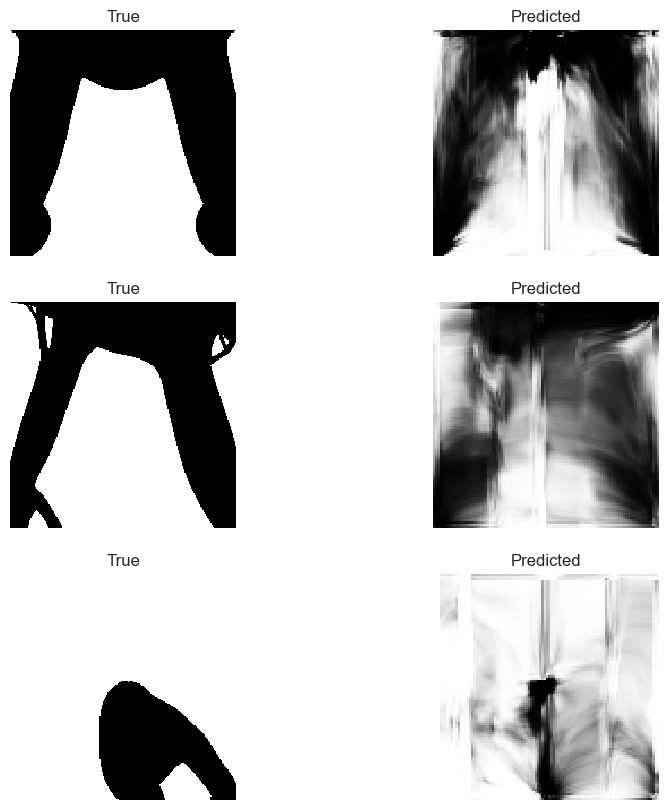

In [32]:
batch_ds = next(test_ds.as_numpy_iterator())
fig, ax = plt.subplots(3, 2, figsize=(10, 10))
for i in range(3):
    x = batch_ds[0][i]
    y_true = batch_ds[1][i]
    y_pred = model.predict(x.reshape((-1, 201, 201, 7)))[0, :, :, 0]
    sns.heatmap(1 - y_true, ax=ax[i, 0], vmin=0, vmax=1, square=True, cmap='gray', cbar=False,
                xticklabels=False, yticklabels=False).invert_yaxis()
    ax[i, 0].set_title('True')
    ax[i, 0].axis("off")
    sns.heatmap(1 - y_pred, ax=ax[i, 1], vmin=0, vmax=1, square=True, cmap='gray', cbar=False,
                xticklabels=False, yticklabels=False).invert_yaxis()
    ax[i, 1].set_title('Predicted')
    ax[i, 1].axis("off")
plt.show()